# Table 1

## Cleaning data 

In [408]:
library(ggplot2)
library(bigrquery)
library(tidyverse)
library(ggplot2)
library(lubridate)
library(stats)
library(finalfit)
ProjectId = "yhcr-prd-bradfor-bia-core"

targetdb2 <- 'yhcr-prd-bradfor-bia-core.CB_FDM_DeathCertificates'
targetdb2 <-gsub(' ','',targetdb2)

targetdb3 <- 'yhcr-prd-bradfor-bia-core.CB_2172'
targetdb3 <- gsub(' ','',targetdb3)


download data from connected bradford and create a master table by left joining the care_home_cohort table to the health characterstics

In [409]:
sql1 <- 
paste(
    'SELECT a.*,imd.imd, bm.bmi, htn.hypertension, bp.systolic_value , ck.ckd_diagnosis, ps.prev_stroke,dm.dm_diagnosis as diabetes_mellitus, af.af_diagnosis, chd.chd_diagnosis, hf.heart_failure as hf_diagnosis, ss.smoking_status, p.no_medication 
from ',targetdb3,'.care_home_cohort_v1 a 
left join ',targetdb3,'.cb_2172_efi2_value b on a.person_id = b.person_id 
left join ',targetdb3,'.efall_value e on a.person_id = e.person_id
left join ',targetdb3,'.cb_2172_polypharmacy p on a.person_id = p.person_id
left join ',targetdb3,'.temp_cb_2172_efi2_bmi bm on a.person_id = bm.person_id
left join ',targetdb3,'.temp_cb_2172_efi2 efi on a.person_id = efi.person_id
left join ',targetdb3,'.cb_2172_ckd_diagnosis ck on a.person_id = ck.person_id
left join ',targetdb3,'.cb_2172_previous_stroke ps on a.person_id = ps.person_id
left join ',targetdb3,'.cb_2172_ch_imd imd on a.person_id = imd.person_id 
left join ',targetdb3,'.cb_2172_dm_diagnosis dm on a.person_id = dm.person_id 
left join ',targetdb3,'.temp_cb_2172_af_diagnosis af on a.person_id = af.person_id
left join ',targetdb3,'.cb_2172_efi2_hf hf on a.person_id = hf.person_id
left join ',targetdb3,'.cb_2172_smoking_status ss on a.person_id = ss.person_id 
left join ',targetdb3,'.cb_2172_chd_diagnosis chd on a.person_id = chd.person_id 
left join ',targetdb3,'.cb_2172_hypertension_combined htn on a.person_id = htn.person_id
left join ',targetdb3,'.cb_2172_bp_post_admission bp on a.person_id = bp.person_id
;',sep="")

bp_tbl <-bq_project_query(ProjectId,sql1)
bp_data <- bq_table_download(bp_tbl)


Auto-refreshing stale OAuth token.



First recode the binary variables as factors 

In [410]:
bp_data$hypertension.factor <- as.factor(bp_data$hypertension)

bp_data <- bp_data %>% select(-hypertension)

In [411]:
bp_data$service.factor <- as.factor(bp_data$admission_service)

bp_data <- bp_data %>% select(-admission_service)

In [412]:
bp_data$body_mass_index <- as.numeric(bp_data$bmi)
bp_data <- bp_data %>% select(-bmi)

In [413]:
bp_data$chronic_kidney_disease <- as.factor(bp_data$ckd_diagnosis)
bp_data$chronic_kidney_disease <- fct_na_value_to_level(bp_data$chronic_kidney_disease, "no")
#bp_data <- bp_data %>% select(-ckd_diagnosis)

In [414]:
bp_data$ethnicity.factor <- as.factor(bp_data$ethnicity_source_value)
bp_data = bp_data %>% select(-ethnicity_source_value)

In [415]:
bp_data <- bp_data %>%
  mutate(
    ethnicity.final = fct_collapse(
      ethnicity.factor,
      "White" = c("White: English or Welsh or Scottish or Northern Irish or British - England and Wales ethnic category 2011 census", 
                  "White: Irish - England and Wales ethnic category 2011 census","White:Any other White background"),
    "Pakistani" = "Asian or Asian British: Pakistani - England and Wales ethnic category 2011 census",
        "Missing" = c("Unknown/Refuse to say", "DEPRECATED")
  ))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `ethnicity.final = fct_collapse(...)`.
Caused by warning:
! Unknown levels in `f`: DEPRECATED”


In [416]:
bp_data$death_date <- as_date(bp_data$dod)
bp_data <- bp_data %>% select(-dod)

In [417]:
bp_data$previous_stroke <- as.factor(bp_data$prev_stroke)

bp_data <- bp_data %>% select(-prev_stroke)

In [418]:
bp_data$gender <- as.factor(bp_data$gender_source_value) %>% fct_na_value_to_level("missing")

#bp_data <- bp_data %>% select (-gender_source_value)

In [419]:
bp_data<- bp_data %>%  mutate(imd.factor = factor(bp_data$imd)) %>% mutate(imd.quintile =
           fct_collapse(imd.factor,"1" = c("1","2"),
                      "2"  = c("4","3"),
                       "3" = c("5","6"),
                         "4" = c("7","8"),
                         "5" = c("9","10")))

In [420]:
bp_data <-bp_data %>% 
  mutate(imd.quintile = imd.quintile %>%
           fct_relevel("1","2","3","4","5","missing")
         )

In [421]:
bp_data$diabetes.factor <- as.factor(bp_data$diabetes_mellitus) %>% fct_na_value_to_level("no")

bp_data <- bp_data %>% select (-diabetes_mellitus)

In [422]:
bp_data$af.factor <- as.factor(bp_data$af_diagnosis) %>% fct_na_value_to_level("no")

bp_data <- bp_data %>% select (-af_diagnosis)

In [423]:
bp_data$hf.factor<- as.factor(bp_data$hf_diagnosis)%>% fct_na_value_to_level("no")

bp_data <- bp_data %>% select (-hf_diagnosis)

In [424]:
bp_data$smoking.factor <- as.factor(bp_data$smoking_status)

bp_data <- bp_data %>%  select(-smoking_status)

code NA values for smoking status as missing factor level 

In [425]:
bp_data$smoking.factor <- fct_na_value_to_level(bp_data$smoking.factor,"missing")
           bp_data$smoking.factor %>% levels()                                 

[1] "current smoker" "ex-smoker"      "non-smoker"     "missing"

In [426]:
bp_data$chd.factor <- as.factor(bp_data$chd_diagnosis) %>% fct_na_value_to_level("no")

bp_data <- bp_data %>% select (-chd_diagnosis)

create factor variable where systolic blood pressure is present or absent 

In [427]:
bp_data <- bp_data %>% mutate(bp_present= case_when(is.na(systolic_value) ~ 'missing',systolic_value > 0 ~ 'yes'))

bp_data$bp_present.factor <- as.factor(bp_data$bp_present)

here we filter the care home cohort for those with a confirmed diagnosis of hypertension at the point of admission. all anaylsis from here on will be restricted to those with a diagnosis of hypertension

In [428]:
bp_data_filtered <- bp_data %>% filter(hypertension.factor == TRUE)

In [429]:
bp_data_filtered %>% group_by(bp_present) %>% summarise(n())

bp_present,n()
<chr>,<int>
missing,435
yes,1593


here I ran some explarotry statistical inference tests to determine whether the missingness of blood pressure values varied significantly between different characteristics 

In [430]:
bp_data_filtered %>% t.test(age_admission ~ bp_present.factor,data=.)


	Welch Two Sample t-test

data:  age_admission by bp_present.factor
t = 0.35799, df = 657.65, p-value = 0.7205
alternative hypothesis: true difference in means between group missing and group yes is not equal to 0
95 percent confidence interval:
 -0.6876766  0.9943286
sample estimates:
mean in group missing     mean in group yes 
             85.54253              85.38920 


In [431]:
#bp_data_filtered %>% t.test(efi2~ bp_present.factor,data=.)

created a new factor variable based on whether blood pressure target was above or below NICE guidelines

In [432]:
bp_data_filtered <- bp_data_filtered %>%  mutate(bp_target= if_else(systolic_value>=150 & age_admission >= 80| systolic_value>=140 & age_admission <80, "above","below", missing=NULL))

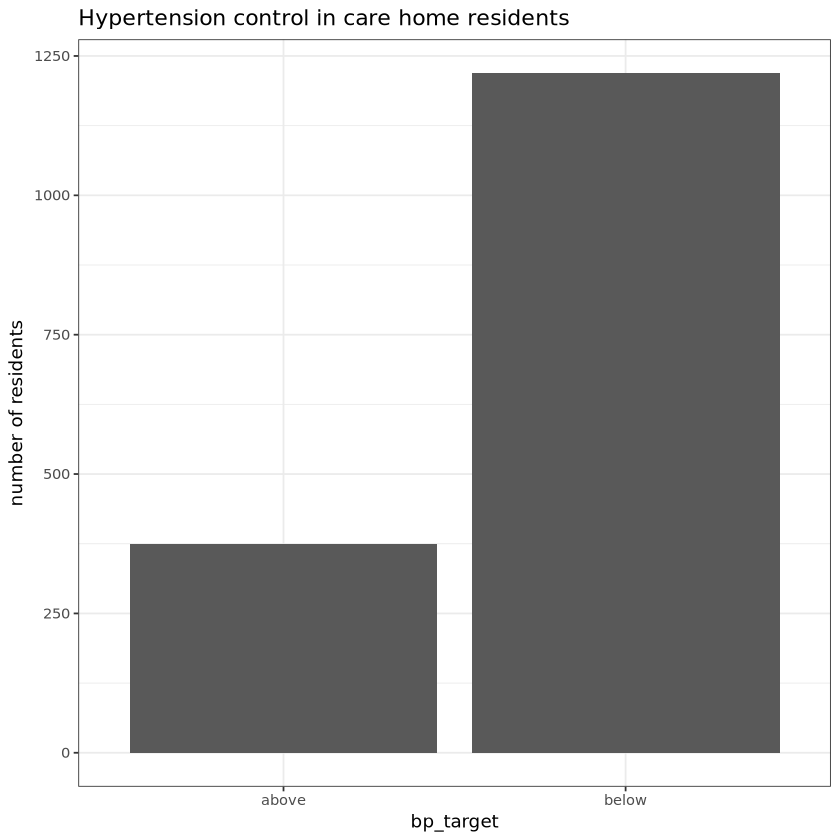

In [433]:
bp_data_filtered %>% filter(systolic_value >0) %>%  ggplot(aes(x= bp_target ))+geom_bar() + theme_bw()  + labs(y= "number of residents", title= "Hypertension control in care home residents")

how many care home residents with hypertension have their blood pressure measured following admission

In [434]:
library(finalfit)
bp_data_filtered %>%  filter(hypertension.factor ==TRUE)%>% 
summary_factorlist(explanatory= "bp_present.factor",
                   ,include_col_totals_percent = TRUE
                   )


No dependent variable(s) provided; defaulting to single-level factor



label,levels,all
<chr>,<chr>,<chr>
bp_present.factor,missing,435 (21.4)
,yes,1593 (78.6)


In [435]:
bp_data_filtered %>% 
  summary_factorlist(dependent = NULL, 
                     explanatory = 
                       c("imd.quintile", "previous_stroke")
  )

No dependent variable(s) provided; defaulting to single-level factor



label,levels,all
<chr>,<chr>,<chr>
imd.quintile,1,593 (29.3)
,2,334 (16.5)
,3,450 (22.2)
,4,255 (12.6)
,5,333 (16.4)
,missing,62 (3.1)
previous_stroke,no,1943 (95.8)
,yes,85 (4.2)


### demographics table

calculate median life exeptancy and create a new variable with mortality in months 

In [436]:
bp_data_filtered$mortality <- as.numeric(bp_data_filtered$mortality)
bp_data_filtered <- bp_data_filtered %>% mutate(mortality_month = round((mortality/30.44),0))
bp_data_filtered$mortality_month %>%  median(na.rm=TRUE)

[1] 16

Warning message:
“Removed 119 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_vline()`).”
Warning message:
“Removed 119 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_vline()`).”


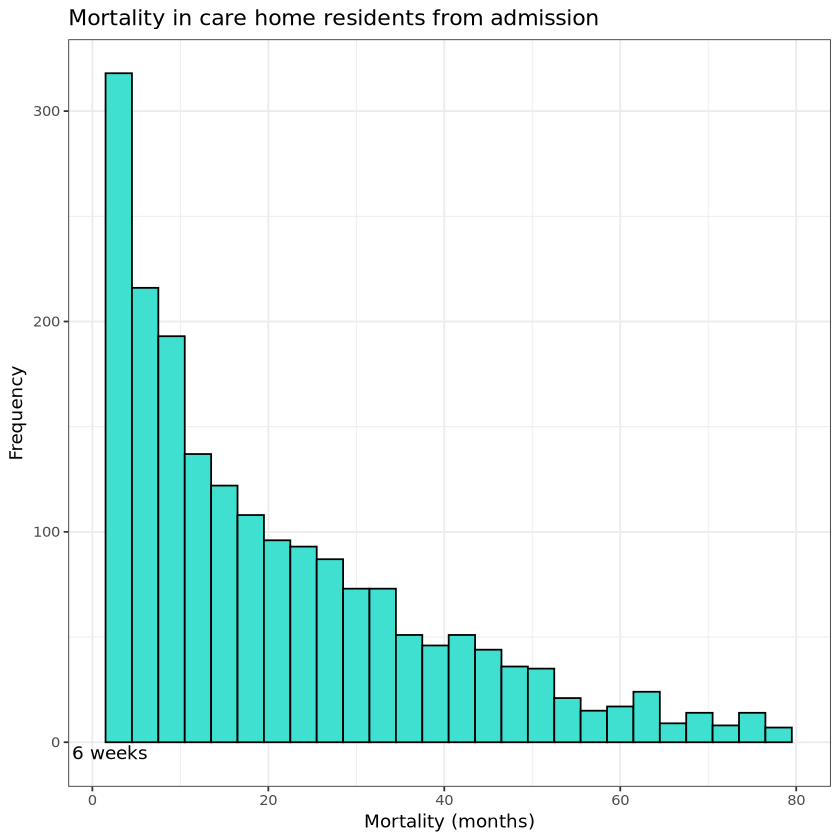

In [437]:
bp_data_filtered %>% ggplot(aes(x=mortality_month))+geom_histogram(binwidth = 3,col="black",fill="turquoise")+
geom_vline(xintercept = median(bp_data_filtered$mortality_month), color = "red", linetype = "dashed", linewidth = 1) +
labs(title = "Mortality in care home residents from admission",x="Mortality (months)",y="Frequency")+
theme_bw()+xlim(1.2,80) + 
annotate("text", x = 2, y = -5, label = "6 weeks")

ggsave("life_exp_hist.png", width = 10, height = 10)

In [438]:
bp_data_filtered %>% 
  mutate(
        age_admission = ff_label(age_admission, "Age at admission"),
      service.factor = ff_label(service.factor,"Service Type"),
      ethnicity.final = ff_label(ethnicity.final,"Ethnicity"),
      admission_length = ff_label(admission_length,"Admission length"),
      mortality = ff_label(mortality,"Lifespan"),
      imd= ff_label(imd,"Index of multiple deprivation(deciles)")
    ) %>% 
summary_factorlist(dependent= NULL, explanatory = c("age_admission","service.factor","gender","imd","ethnicity.final","admission_length","mortality") ) 

No dependent variable(s) provided; defaulting to single-level factor



label,levels,all
<chr>,<chr>,<chr>
Age at admission,Mean (SD),85.4 (7.6)
Service Type,Nursing,1140 (56.2)
,Residential,888 (43.8)
gender,F,1329 (65.5)
,M,699 (34.5)
,missing,0 (0.0)
Index of multiple deprivation(deciles),1,409 (20.2)
,10,180 (8.9)
,2,184 (9.1)


## Cardiovascular Risk Factors 

In [439]:
bp_data_filtered %>% 

summary_factorlist(dependent= NULL, explanatory = c("age_admission","body_mass_index","af.factor","chronic_kidney_disease","hf.factor","chd.factor","diabetes.factor","smoking.factor","previous_stroke") )

No dependent variable(s) provided; defaulting to single-level factor



label,levels,all
<chr>,<chr>,<chr>
age_admission,Mean (SD),85.4 (7.6)
body_mass_index,Mean (SD),24.8 (6.8)
af.factor,no,1569 (77.4)
,yes,459 (22.6)
chronic_kidney_disease,yes,715 (35.3)
,no,1313 (64.7)
hf.factor,yes,331 (16.3)
,no,1697 (83.7)
chd.factor,yes,505 (24.9)


## Electronic frailty index 2

In [440]:
bp_data <- bp_data %>% 
  mutate(
    efi2.factor = 
      efi2 %>%
      cut(breaks = c(0,0.12,0.24,0.36,0.999), include.lowest= TRUE) %>% 
      fct_recode(
        "fit"      =  "[0,0.12]",
        "mild frailty" = "(0.12,0.24]",
        "moderate frailty" = "(0.24,0.36]",
        "severe frailty"  = "(0.36,0.999]"
      ) %>% 
      ff_label("Efi2 category"))



ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `efi2.factor = `%>%`(...)`.
[1mCaused by error:[22m
[33m![39m object 'efi2' not found


In [ ]:
bp_data %>% summary_factorlist(dependent = c("service.factor"),explanatory=c("efi2.factor"))

In [ ]:
efi2 <- bp_data %>% group_by(efi2.factor,service.factor) %>% summarise(freq=n())%>% mutate(percentage=(round(freq/sum(freq),3))*100)

efi2

In [ ]:
efi2%>%  ggplot(aes(fill=service.factor,x=efi2.factor,y= percentage))+ geom_col(fill='dark green') + theme_bw()+labs(x= "Electronic frailty index 2")+expand_limits(y=100)+geom_text(aes(label = percentage),vjust = 0)

In [ ]:
bp_data %>% 

summary_factorlist(dependent= NULL, explanatory = c("efi2","efall_value") )

In [ ]:
bp_data %>%  ggplot(aes(x= life_exp ))+ geom_histogram(bins=50) + theme_bw()

## Hypertension Prevalence

In [ ]:
bp_data %>% summary_factorlist(dependent=NULL, explanatory = c("hypertension.factor"),na_to_prop=TRUE)

In [ ]:
 binom.test(2028,(766+2028), conf.level = 0.95)

In [ ]:
bp_data$bp_reading_factor <- as.factor(bp_data$bp_present)

# Antihypertensive medicaiton 

i filtered out those with a mortality less than 6 months for the anaylsis below 

In [442]:
sql_med<- paste('SELECT * from `CB_2172.cb_2172_antihypertensive_long_format` where person_id in (select person_id from ',targetdb3,'.care_home_cohort_v1 ) ;',sep="")

tbl_med <-bq_project_query(ProjectId,sql_med)

tbl_med <- bq_table_download(tbl_med)

tbl_med_f <- tbl_med

In [443]:
#switch time_status and medication binary variables to factor variables 
tbl_med_f$time_status.factor <- as.factor(tbl_med_f$time_status)

tbl_med_f <- tbl_med_f %>% select(-time_status)

In [444]:
tbl_med_ef <- tbl_med_f %>% filter(!( time_status.factor == "post_admission" & early_death == "true"))


### this section will produce a table of the type of antihypertensives prescribed and how this changes during admission in those with hypertension

In [445]:
tbl_med_class <-tbl_med_ef

In [446]:
tbl_med_class$beta_blocker.factor <- as.factor(tbl_med_class$beta_blocker)

tbl_med <- tbl_med_class %>% select(-beta_blocker)

In [447]:
tbl_med_class$calcium_channel_blocker.factor <- as.factor(tbl_med_class$calcium_channel_blocker)

tbl_med_class <- tbl_med_class %>% select(-calcium_channel_blocker)

In [448]:
tbl_med_class$thiazide.factor <- as.factor(tbl_med_class$thiazide_type_diuretic)

tbl_med_class <- tbl_med_class %>% select(-thiazide_type_diuretic)

In [449]:
tbl_med_class$angiotensin_receptor_blocker.factor <- as.factor(tbl_med_class$angiotensin_receptor_blocker)

tbl_med_class <- tbl_med_class %>% select(-angiotensin_receptor_blocker)

In [450]:
tbl_med_class$ace_inhibitor.factor <- as.factor(tbl_med_class$ace_inhibitor)

tbl_med_class <- tbl_med_class %>% select(-ace_inhibitor)

In [451]:
tbl_med_class$alpha_blocker.factor <- as.factor(tbl_med_class$alpha_blocker)

tbl_med_class <- tbl_med_class %>% select(-alpha_blocker)


In [452]:
tbl_med_class$early_death.factor <- as.factor(tbl_med_class$early_death)

tbl_med_class <- tbl_med_class %>% select(-early_death)

In [453]:
tbl_med$time_status.factor %>% levels()

[1] "admission"      "post_admission" "pre_admission"

In [454]:
 tbl_med_class <- tbl_med_class %>% 
  mutate(time_status.factor = time_status.factor %>% 
           fct_relevel("pre_admission"))

tbl_med_class$time_status.factor %>% levels()

[1] "pre_admission"  "admission"      "post_admission"

In [455]:
tbl_med_class %>% summary_factorlist(dependent   ="time_status.factor" , 
                     explanatory = c("calcium_channel_blocker.factor", "beta_blocker.factor","ace_inhibitor.factor","angiotensin_receptor_blocker.factor","alpha_blocker.factor","thiazide.factor"))


label,levels,pre_admission,admission,post_admission
<chr>,<chr>,<chr>,<chr>,<chr>
calcium_channel_blocker.factor,false,1804 (89.0),1861 (91.8),1483 (93.1)
,true,224 (11.0),167 (8.2),110 (6.9)
beta_blocker.factor,false,1601 (78.9),1637 (80.7),1292 (81.1)
,true,427 (21.1),391 (19.3),301 (18.9)
ace_inhibitor.factor,false,1693 (83.5),1837 (90.6),1457 (91.5)
,true,335 (16.5),191 (9.4),136 (8.5)
angiotensin_receptor_blocker.factor,false,1879 (92.7),1942 (95.8),1537 (96.5)
,true,149 (7.3),86 (4.2),56 (3.5)
alpha_blocker.factor,false,1975 (97.4),2001 (98.7),1577 (99.0)


### this next section will etermine the number of antihypertnesives prescribed for each inidiudal and how this changes ove rthe course of an admission 

In [456]:
tbl_antihypertensive_class <- tbl_med_class %>%  filter(time_status.factor == 'admission')

In [457]:
#convert medication data into long format

In [458]:
tbl_med_long <- tbl_med_ef %>% pivot_longer(beta_blocker:alpha_blocker,names_to = "antihypertensive",values_to= "prescribed")

tbl_med_long_bb <- tbl_med_ef %>%  pivot_longer(beta_blocker:alpha_blocker,names_to = "antihypertensive",values_to= "prescribed") %>% filter(!(antihypertensive == "beta_blocker"))

In [459]:
#recode antihypertenisve classess as factor vectors

In [460]:
tbl_med_long$antihypertensive.factor <- as.factor(tbl_med_long$antihypertensive)
tbl_med_long<- tbl_med_long %>% select(-antihypertensive)

In [461]:
tbl_med_long_bb$antihypertensive.factor <- as.factor(tbl_med_long_bb$antihypertensive)
tbl_med_long_bb<- tbl_med_long_bb %>% select(-antihypertensive)

In [462]:
tbl_med_long_bb$prescribed.factor <- as.factor(tbl_med_long_bb$prescribed)
tbl_med_long_bb<- tbl_med_long_bb %>% select(-prescribed)

In [463]:
#this was attempt at trying to do the group_by function in R< but didn't work so i just sent it back to bigquery and did it there because i know how to do it with SQL
#tbl_med_long_filtered <- tbl_med_long  %>%   group_by(person_id, tbl_med_long$time_status.factor)%>% summarise(antihypertensive.factor)

In [464]:
names(tbl_med_long)[names(tbl_med_long) == "antihypertensive.factor"] <- "antihypertensive_type"
names(tbl_med_long)[names(tbl_med_long) == "time_status.factor"] <- "time_factor"

In [465]:
names(tbl_med_long_bb)[names(tbl_med_long_bb) == "antihypertensive.factor"] <- "antihypertensive_type"
names(tbl_med_long_bb)[names(tbl_med_long_bb) == "time_status.factor"] <- "time_factor"

## this bit is to generate a graph  showing  changes in prescribing by medication class minus beta-blockers


In [466]:
tbl_med_long_bb_grouped <- tbl_med_long_bb %>% group_by(antihypertensive_type,time_factor,prescribed.factor)%>% summarise(sub_total = n())

`summarise()` has grouped output by 'antihypertensive_type', 'time_factor'. You
can override using the `.groups` argument.


In [467]:
tbl_med_long_bb_grouped_percentage <- tbl_med_long_bb_grouped %>% group_by(time_factor,antihypertensive_type)%>% mutate(total = sum(sub_total))%>% mutate(percentage_prescribed = (sub_total/total)*100) %>%   mutate(time_factor = time_factor %>% 
           fct_relevel("pre_admission"))


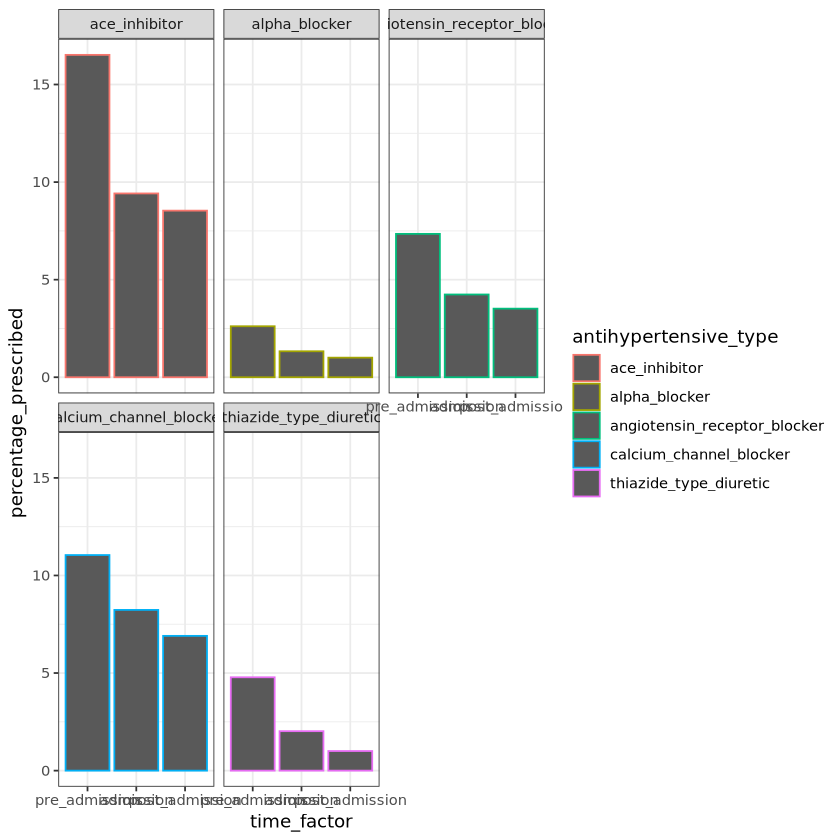

In [468]:
tbl_med_long_bb_grouped_percentage %>% filter(prescribed.factor == "true") %>% ggplot(aes(x=time_factor,y=percentage_prescribed,colour=antihypertensive_type))+geom_col()+theme_bw()+facet_wrap("antihypertensive_type")

In [469]:
mybq = bq_table(project='yhcr-prd-bradfor-bia-core', dataset='CB_2172', table='tbl_med_long_filtered')
bq_table_upload(x=mybq, values= tbl_med_long, create_disposition='CREATE_IF_NEEDED', 
             write_disposition='WRITE_TRUNCATE')

In [471]:
sql4<- paste(
    'SELECT person_id, time_factor, avg(no_antihypertensive) as number_antihypertensive 
FROM `yhcr-prd-bradfor-bia-core.CB_2172.tbl_med_long_filtered` 
group by person_id, time_factor 
order by person_id, time_factor;'
             ,sep="")

tbl_antihtn <-bq_project_query(ProjectId,sql4)

tbl_antihtn <- bq_table_download(tbl_antihtn)



In [472]:
sql5<- paste(
    'SELECT person_id, time_factor, avg(no_antihypertensive) as number_antihypertensive 
FROM `yhcr-prd-bradfor-bia-core.CB_2172.tbl_med_long_filtered_minus_bb` 
group by person_id, time_factor 
order by person_id, time_factor;'
             ,sep="")

tbl_antihtn_1 <-bq_project_query(ProjectId,sql5)

tbl_antihtn_minus_bb <- bq_table_download(tbl_antihtn_1)



In [473]:
 tbl_antihtn$number_antihypertensive.factor <- as.factor(tbl_antihtn$number_antihypertensive)%>% fct_collapse("4+"=c(4,5))
 tbl_antihtn$time.factor <- as.factor(tbl_antihtn$time_factor)

In [474]:
 tbl_antihtn <- tbl_antihtn %>% 
  mutate(time.factor = time.factor %>% 
           fct_relevel("pre_admission"))


In [475]:
deprescribing_tibble <- tbl_antihtn %>% 
summary_factorlist(dependent   ="time.factor", 
                     explanatory = c("number_antihypertensive.factor"),add_col_totals =TRUE)

deprescribing_tibble

label,levels,pre_admission,admission,post_admission
<chr>,<chr>,<chr>,<chr>,<chr>
Total N (%),,2028 (35.9),2028 (35.9),1593 (28.2)
number_antihypertensive.factor,0,1126 (55.5),1341 (66.1),1084 (68.0)
,1,587 (28.9),501 (24.7),403 (25.3)
,2,251 (12.4),159 (7.8),87 (5.5)
,3,61 (3.0),24 (1.2),18 (1.1)
,4+,3 (0.1),3 (0.1),1 (0.1)


In [476]:
tbl_antihtn_group_1 <- tbl_antihtn %>% group_by(number_antihypertensive.factor,time.factor) %>% mutate(total_time_class =sum(n()))

tbl_antihtn_group_2 <- tbl_antihtn_group_1 %>% group_by(time.factor) %>% mutate(total_time = sum(n())) %>% mutate(percentage_class_time = (total_time_class/total_time * 100))

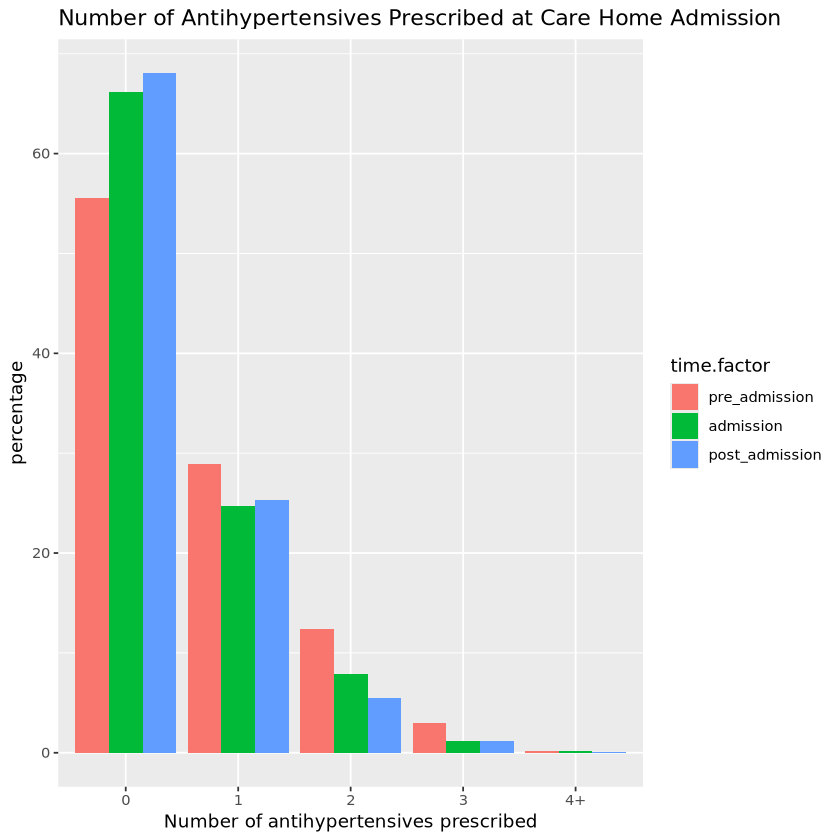

In [477]:
tbl_antihtn_group_2 %>% ggplot( aes(fill=time.factor, y=percentage_class_time, x=number_antihypertensive.factor)) + 
    geom_bar(position="dodge", stat="identity")+  ggtitle("Number of Antihypertensives Prescribed at Care Home Admission")+ 
    xlab("Number of antihypertensives prescribed")+ylab("percentage")

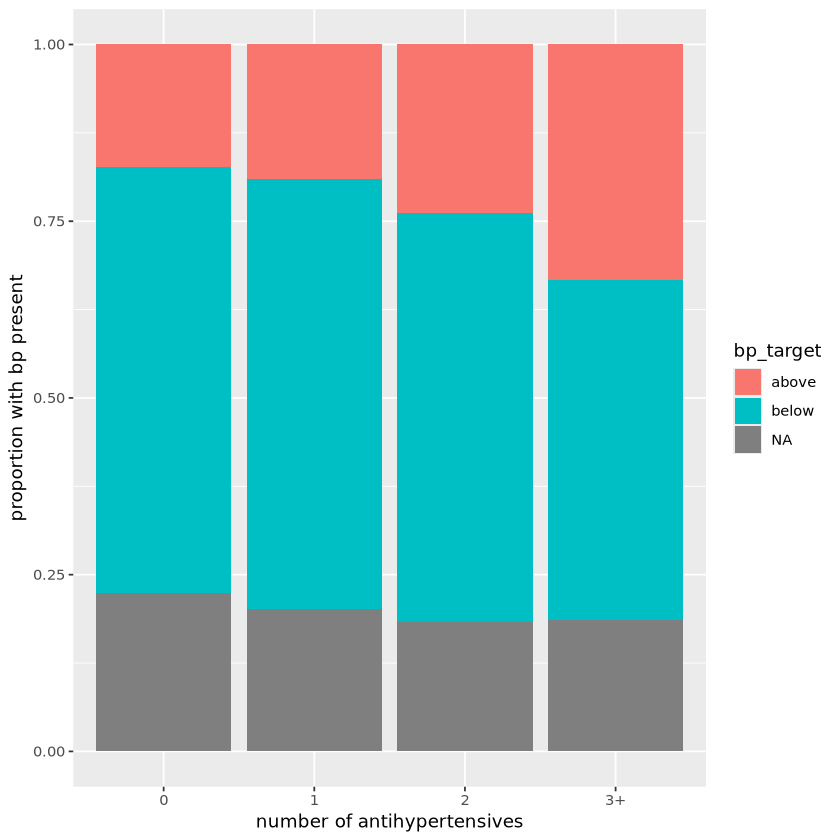

In [478]:
master_tibble %>% ggplot(aes(x=number_antihypertensive.factor,fill=bp_target))+geom_bar(position="fill")+labs(x="number of antihypertensives",y="proportion with bp present")

Note: dependent includes missing data. These are dropped.



label,levels,above,below,p
<chr>,<chr>,<chr>,<chr>,<chr>
number_antihypertensive.factor,0,232 (62.0),809 (66.4),0.073
,1,95 (25.4),305 (25.0),
,2,38 (10.2),92 (7.5),
,3+,9 (2.4),13 (1.1),


## we then repeat the above analysis but minus beta blockers

In [479]:
 tbl_antihtn_minus_bb$number_antihypertensive.factor <- as.factor(tbl_antihtn_minus_bb$number_antihypertensive)%>% fct_collapse("3+"=c(3,4,5))
 tbl_antihtn_minus_bb$time.factor <- as.factor(tbl_antihtn_minus_bb$time_factor)

In [480]:
 tbl_antihtn_minus_bb <- tbl_antihtn_minus_bb %>% 
  mutate(time.factor = time.factor %>% 
           fct_relevel("pre_admission"))


In [481]:
deprescribing_tibble <- tbl_antihtn_minus_bb %>% 
summary_factorlist(dependent   ="time.factor", 
                     explanatory = c("number_antihypertensive.factor"),add_col_totals =TRUE)

deprescribing_tibble

label,levels,pre_admission,admission,post_admission
<chr>,<chr>,<chr>,<chr>,<chr>
Total N (%),,2028 (35.9),2028 (35.9),1593 (28.2)
number_antihypertensive.factor,0,1126 (55.5),1341 (66.1),1084 (68.0)
,1,587 (28.9),501 (24.7),403 (25.3)
,2,251 (12.4),159 (7.8),87 (5.5)
,3+,64 (3.2),27 (1.3),19 (1.2)


In [482]:
tbl_antihtn_minus_bb_group_1 <- tbl_antihtn_minus_bb %>% group_by(number_antihypertensive.factor,time.factor) %>% mutate(total_time_class =sum(n()))

tbl_antihtn_minus_bb_group_2 <- tbl_antihtn_minus_bb_group_1 %>% group_by(time.factor) %>% mutate(total_time = sum(n())) %>% mutate(percentage_class_time = (total_time_class/total_time * 100))

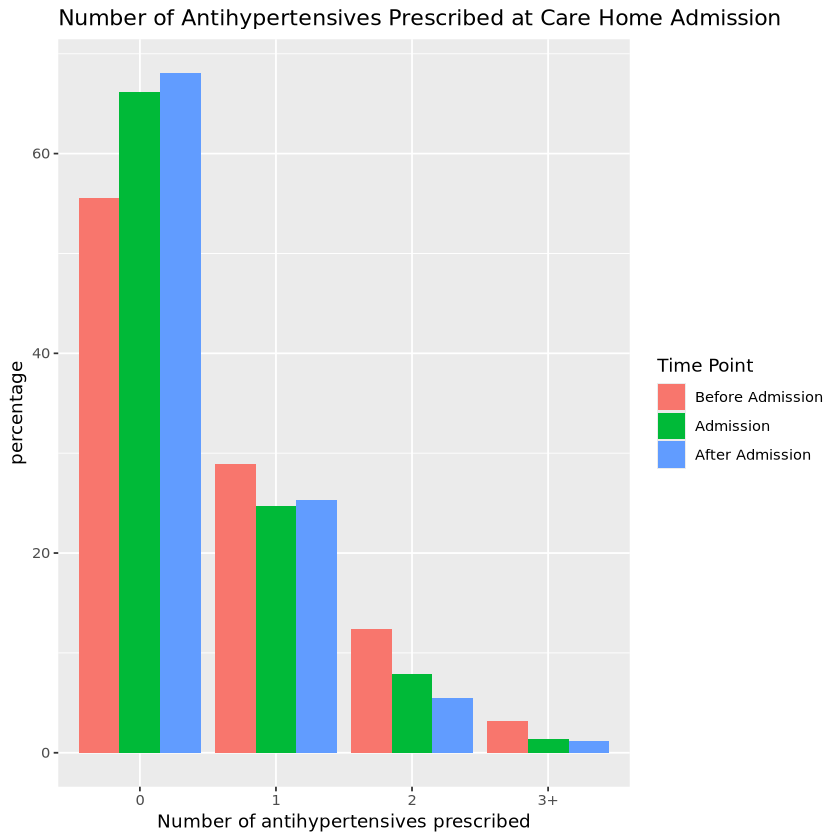

In [483]:
tbl_antihtn_minus_bb_group_2 %>% ggplot( aes(fill=time.factor, y=percentage_class_time, x=number_antihypertensive.factor)) + 
    geom_bar(position="dodge", stat="identity")+  ggtitle("Number of Antihypertensives Prescribed at Care Home Admission")+ 
    xlab("Number of antihypertensives prescribed")+ylab("percentage")+scale_fill_discrete("Time Point",labels=c('Before Admission', 'Admission','After Admission'))

## Blood pressure measurements

In [484]:
# join the number of medications at admission to the master cohort dataframe in order to calculate number of people with BP measurements after admission by number of medication 

In [497]:
no_medication <- tbl_antihtn_minus_bb %>% filter(time.factor == 'admission')

In [498]:
master_tibble<-bp_data_filtered %>% inner_join(no_medication, by="person_id")


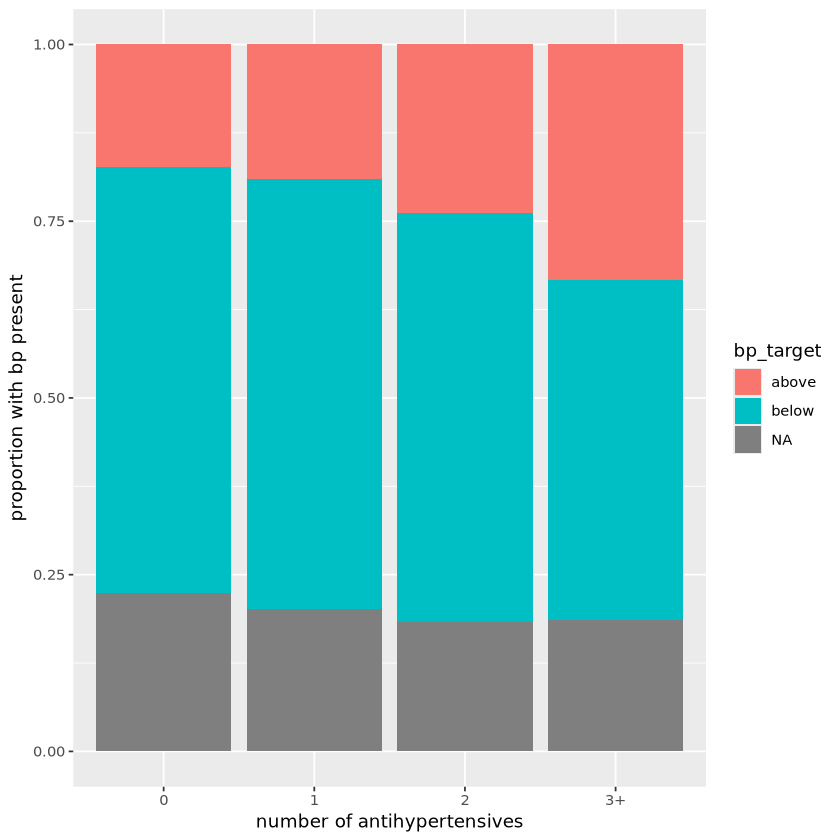

In [495]:
master_tibble %>% ggplot(aes(x=number_antihypertensive.factor,fill=bp_target))+geom_bar(position="fill")+labs(x="number of antihypertensives",y="proportion with bp present")

In [499]:
master_tibble %>%  summary_factorlist(dependent   ="bp_target", 
                     explanatory = c("number_antihypertensive.factor"),p=TRUE)

Note: dependent includes missing data. These are dropped.



label,levels,above,below,p
<chr>,<chr>,<chr>,<chr>,<chr>
number_antihypertensive.factor,0,232 (62.0),809 (66.4),0.073
,1,95 (25.4),305 (25.0),
,2,38 (10.2),92 (7.5),
,3+,9 (2.4),13 (1.1),
